# Resampling Planck 2018

The Planck analysis is similar to the DES analysis in that it is high dimensional (it also has 27 free parameters), but differs in that many more parameters are well constrained. In this notebook, we will attempt to interpolate the Planck posterior probability distribution as a function of the parameters in the chain.

In [1]:
#Import things
import numpy as np
import matplotlib.pyplot as plt
import resampler as samp
import scipy.optimize as op
import chainconsumer as CC
import emcee #for doing MCMC
%matplotlib inline

In [2]:
#Plot formatting
plt.rc("font", size=18, family="serif")
plt.rc("text", usetex=True)

In [3]:
#Read in the chain
input_chain = np.load("Planck_data/Planck_params.npy")
lnpost = np.load("Planck_data/Planck_lnpost.npy")
weights = np.load("Planck_data/Planck_weights.npy")
print("chain shape is   ", input_chain.shape)
print("lnpost shape is  ", lnpost.shape)
print("weights shape is ", weights.shape)

('chain shape is   ', (24497, 27))
('lnpost shape is  ', (24497,))
('weights shape is ', (24497,))


In [4]:
#Pick out training points
N_training = 700
RS = samp.resampler(input_chain, lnpost, scale = 8)
RS.select_training_points(N_training, method="LH")
#Train the GP inside of the sampler
RS.train()

      fun: 42353.90239742706
 hess_inv: array([[2.39606791e-07]])
      jac: array([4.92845429e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 81
      nit: 11
     njev: 69
   status: 2
  success: False
        x: array([4.46265295])


In [5]:
start = input_chain[np.argmax(lnpost)]

nwalkers = 200
ndim = len(input_chain[0])

sampler = emcee.EnsembleSampler(nwalkers, ndim, RS.predict)

print("Running first burn-in")
p0 = np.array([start + start*1e-3*np.random.randn(ndim) for i in range(nwalkers)])
p0, lp, _ = sampler.run_mcmc(p0, 1000)
print("Running second burn-in")
p0 = p0[np.argmax(lp)] + p0[np.argmax(lp)]*1e-4*np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 1500)
sampler.reset()
print("Running production...")
sampler.run_mcmc(p0, 5000);

Running first burn-in
Running second burn-in
Running production...


In [6]:
test_chain = sampler.flatchain

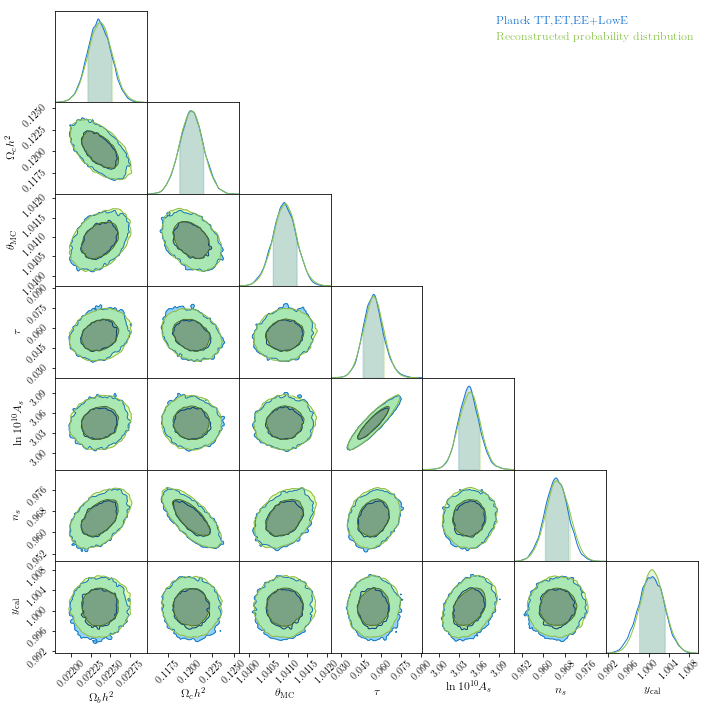

In [8]:
c2 = CC.ChainConsumer()

labels = [r"$\Omega_bh^2$", r"$\Omega_ch^2$", r"$\theta_{\rm MC}$", r"$\tau$", r"$\ln 10^{10}A_s$", 
          r"$n_s$", r"$y_{\rm cal}$"]


c2.add_chain(input_chain[:,:7], parameters=labels, name="Planck TT,ET,EE+LowE", weights=weights)
c2.add_chain(test_chain[:,:7], parameters=labels, name="Reconstructed probability distribution")
c.configure(legend_kwargs={"fontsize": 32})

fig = c2.plotter.plot()

In [9]:
#fig.savefig("Planck2018_resampling_example.png", dpi=300, bbox_inches="tight")
#fig.savefig("Planck2018_resampling_example.pdf", bbox_inches="tight")

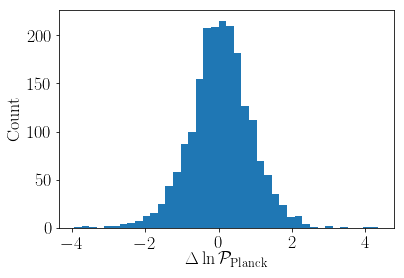

In [10]:
#Error on the prediction - looking at the differene in chi^2
inds = RS.training_inds
allinds = np.arange(len(input_chain))
allinds = np.delete(allinds, inds)
allinds = np.random.choice(allinds, size=2000, replace=False)
lnL_predict = RS.predict(input_chain[allinds])

lnL_train = lnpost[allinds]

lnL_diff = lnL_predict - lnL_train
chi2_diff = lnL_train - lnL_predict

plt.hist(chi2_diff, bins=40)
plt.xlabel(r"$\Delta\ln\mathcal{P}_{\rm Planck}$")
plt.ylabel("Count")
plt.savefig("Planck_chi2_error.png", dpi=300, bbox_inches="tight")
plt.savefig("Planck_chi2_error.pdf", bbox_inches="tight")

In [12]:
true_means = np.mean(input_chain, 0)
test_means = np.mean(test_chain, 0)
true_std = np.std(input_chain, 0)
test_std = np.std(test_chain, 0)
print("True mean; Test mean; sample error")
for i in range(len(true_means)):
    print("%.3e;     %.3e,     %.3e"%(true_means[i], test_means[i], true_std[i]/np.sqrt(len(input_chain))))

True mean; Test mean; sample error
2.236e-02;     2.237e-02,     9.629e-07
1.202e-01;     1.202e-01,     8.856e-06
1.041e+00;     1.041e+00,     1.996e-06
5.445e-02;     5.456e-02,     5.105e-05
3.045e+00;     3.046e+00,     1.031e-04
9.649e-01;     9.654e-01,     2.824e-05
1.000e+00;     1.001e+00,     1.616e-05
4.659e+01;     4.770e+01,     4.223e-02
5.259e-01;     4.800e-01,     1.814e-03
5.442e+00;     6.686e+00,     1.237e-02
2.585e+02;     2.531e+02,     1.767e-01
4.576e+01;     4.736e+01,     5.025e-02
4.222e+01;     4.611e+01,     5.875e-02
1.152e+02;     1.176e+02,     6.493e-02
3.380e+00;     1.109e+00,     1.520e-02
8.871e+00;     8.893e+00,     1.169e-02
1.087e+01;     1.090e+01,     1.134e-02
1.855e+01;     1.919e+01,     2.104e-02
9.374e+01;     9.383e+01,     4.686e-02
1.142e-01;     1.134e-01,     2.447e-04
1.352e-01;     1.349e-01,     1.883e-04
4.801e-01;     4.825e-01,     5.438e-04
2.264e-01;     2.263e-01,     3.420e-04
6.669e-01;     6.724e-01,     5.143e-04
2.089